In [1]:
"""
# 2D and 3D Bayesian Hilbert Maps with pytorch
# Ransalu Senanayake
"""
import torch as pt
import matplotlib.pyplot as plt
import numpy as np
import time


import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel
import sys
#import util
import time as comp_timer
from sklearn.linear_model._base import LinearClassifierMixin, BaseEstimator
from scipy.special import expit
from scipy.linalg import solve_triangular

class SBHM(LinearClassifierMixin, BaseEstimator):
    def __init__(self, gamma=0.075*0.814, grid=None, cell_resolution=(5, 5), cell_max_min=None, X=None, calc_loss=False):
        """
        :param gamma: RBF bandwidth
        :param grid: if there are prespecified locations to hinge the RBF
        :param cell_resolution: if 'grid' is 'None', resolution to hinge RBFs
        :param cell_max_min: if 'grid' is 'None', realm of the RBF field
        :param X: a sample of lidar locations to use when both 'grid' and 'cell_max_min' are 'None'
        """
        self.gamma = gamma
        if grid is not None:
            self.grid = grid
        else:
            self.grid = self.__calc_grid_auto(cell_resolution, cell_max_min, X)
        self.calc_loss = calc_loss
        self.intercept_, self.coef_, self.sigma_ = [0], [0], [0]
        self.scan_no = 0
        print('D=', self.grid.shape[0])

    def __calc_grid_auto(self, cell_resolution, max_min, X):
        """
        :param X: a sample of lidar locations
        :param cell_resolution: resolution to hinge RBFs as (x_resolution, y_resolution)
        :param max_min: realm of the RBF field as (x_min, x_max, y_min, y_max)
        :return: numpy array of size (# of RNFs, 2) with grid locations
        """

        if max_min is None:
            # if 'max_min' is not given, make a boundarary based on X
            # assume 'X' contains samples from the entire area
            expansion_coef = 1.2
            x_min, x_max = expansion_coef*X[:, 0].min(), expansion_coef*X[:, 0].max()
            y_min, y_max = expansion_coef*X[:, 1].min(), expansion_coef*X[:, 1].max()
        else:
            x_min, x_max = max_min[0], max_min[1]
            y_min, y_max = max_min[2], max_min[3]

        xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_resolution[0]), \
                             np.arange(y_min, y_max, cell_resolution[1]))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

        return grid

    def __sparse_features(self, X):
        """
        :param X: inputs of size (N,2)
        :return: hinged features with intercept of size (N, # of features + 1)
        """
        rbf_features = rbf_kernel(X, self.grid, gamma=self.gamma)
        return np.hstack((np.ones(X.shape[0])[:, np.newaxis], rbf_features))

    def __lambda(self, epsilon):
        """
        :param epsilon: epsilon value for each data point
        :return: local approximation
        """
        return 0.5/epsilon*(expit(epsilon)-0.5)

    def __calc_loss(self, X, mu0, Sig0_inv, mu, Sig_inv, Ri, epsilon):
        # TODO
        Sig = np.dot(Ri.T, Ri)
        R0 = np.linalg.cholesky(Sig0_inv)
        R0i = solve_triangular(R0, np.eye(X.shape[1]), lower=True)
        S0 = np.dot(R0i.T, R0i)
        loss = 0.5 * np.linalg.slogdet(Sig)[1] - 0.5 * np.linalg.slogdet(S0)[1] + 0.5 * mu.T.dot(Sig_inv.dot(mu)) - 0.5 * mu0.T.dot(Sig0_inv.dot(mu0))
        loss += (np.sum(np.log(expit(epsilon)) - 0.5 * epsilon + self.__lambda(epsilon) * epsilon ** 2))

        return loss

    def __calc_posterior(self, X, y, epsilon, mu0, Sig0_inv, full_covar=False):
        """
        :param X: positions
        :param y: labels
        :param epsilon:
        :param mu0: mean
        :param Sig0_inv: inverse of covariance
        :param full_covar: whether to output the full covariance or not
        :return: mean, inverse of covariance, Cholesky factor
        """

        lam = self.__lambda(epsilon)

        Sig_inv = Sig0_inv + 2 * np.dot(X.T*lam, X)

        m_right = Sig0_inv.dot(mu0) + np.dot(X.T, (y - 0.5))
        L_of_Sig_inv = np.linalg.cholesky(Sig_inv)
        Z = solve_triangular(L_of_Sig_inv, m_right, lower=True)
        mu = solve_triangular(L_of_Sig_inv.T, Z, lower=False)

        L_inv_of_Sig_inv = solve_triangular(L_of_Sig_inv, np.eye(X.shape[1]), lower=True)

        if full_covar:
            Sig = np.dot(L_inv_of_Sig_inv.T, L_inv_of_Sig_inv)
            return mu, Sig
        else:
            return mu, Sig_inv, L_inv_of_Sig_inv

    def fit(self, X, y):
        """
        :param X: Positions (N x 2)
        :param y: labels (N,)
        """

        # If first run, set m0, S0i
        if self.scan_no == 0:
            self.mu = np.zeros((self.grid.shape[0] + 1))
            self.Sig_inv = 0.0001 * np.eye((self.grid.shape[0] + 1)) #0.01 for sim, 0
            self.n_iter = 10
        else:
            self.n_iter = 1

        epsilon = 1
        X_orig = copy.copy(X)

        for i in range(self.n_iter):
            X = self.__sparse_features(X_orig)

            # E-step: update Q(w)
            self.mu, self.Sig_inv, self.Ri = self.__calc_posterior(X, y, epsilon, self.mu, self.Sig_inv)

            # M-step: update epsilon
            XMX = np.dot(X, self.mu)**2
            XSX = np.sum(np.dot(X, self.Ri.T) ** 2, axis=1)
            epsilon = np.sqrt(XMX + XSX)

            # Calculate loss, if specified
            if self.calc_loss is True:
                print("  scan={}, iter={} => loss={:.1f}".format(self.scan_no, i,
                      self.__calc_loss(X, np.zeros((self.grid.shape[0] + 1)), 0.01*np.eye((self.grid.shape[0] + 1)),
                        self.mu, self.Sig_inv, self.Ri, epsilon)))

        self.intercept_ = [0]
        coef_, sigma_ = self.__calc_posterior(X, y, epsilon, self.mu, self.Sig_inv, True)

        self.intercept_ = 0
        self.coef_[0] = coef_
        self.sigma_[0] = sigma_
        self.coef_ = np.asarray(self.coef_)
        self.scan_no += 1

    def predict_proba(self, X_q):
        """
        :param X_q: Query positions (N x 2)
        :return: (free prob, occupance prob)
        """

        X_q = self.__sparse_features(X_q)#[:, 1:]
        scores = self.decision_function(X_q)

        sigma = np.asarray([np.sum(np.dot(X_q, s) * X_q, axis=1) for s in self.sigma_])
        ks = 1. / (1. + np.pi * sigma / 8) ** 0.5
        probs = expit(scores.T * ks).T
        if probs.shape[1] == 1:
            probs = np.hstack([1 - probs, probs])
        else:
            probs /= np.reshape(np.sum(probs, axis=1), (probs.shape[0], 1))
        return probs
   

/home/ssnyde9/anaconda3/envs/army-vsa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1668658/384482086.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import os

BASE_CONFIG: dict = {
    "experiment_name": "build_vsa_map",
    "verbose": True,
    "data": {
        "dataset_name": "toysim", # toysim, intel
        "test_split": 0.1,
        "toysim": {
            "data_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/datasets/single/toysim0/npz",
            "file_prefix": "results_frame_",
            "file_suffix": ".npz",
            "world_bounds": [-50, 50, -50, 50] # x_min, x_max, y_min, y_max; meters
        },
        "intel": {
            "data_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/datasets/single/intel.csv",
            "world_bounds": [-20, 20, -25, 15] # x_min, x_max, y_min, y_max; meters
        },
    },
    "logging": {
        "log_dir": os.path.expanduser("~") + "/dev/highfrost/highfrost/ogm/experiments/logs",
        "occupied_map_dir": "occupied_maps",
        "empty_map_dir": "empty_maps",
        "global_maps_dir": "global_maps",
        "run_time_metrics": "run_time_metrics.pkl"
    }
}

import highfrost.ogm.dataloaders.functional as hogmf
from omegaconf import DictConfig

config: DictConfig = DictConfig(BASE_CONFIG)

In [3]:
from highfrost.ogm.utilities import train_test_split

dataloader, world_size = hogmf.load_single_data(config)

output = dataloader.reset()
num_correct: int = 0
num_total: int = 0

test_split: float = config.data.test_split
test_data: dict = {
    "lidar_data": [],
    "occupancy": []
}

gamma = 0.5

cell_resolution = (1.0, 1.0)
cell_max_min = [-50, 50, -50, 50]
thresh = 0.01
gamma=6.71



Loading Data...


In [4]:
import copy
totalTime = 0

test_split: float = config.data.test_split
test_data: dict = {
    "lidar_data": [],
    "occupancy": []
}

for i in range(dataloader.max_steps())[:]:

    train_lidar, train_occupancy, test_lidar, test_occupancy = train_test_split(output, test_split)
    test_data["lidar_data"].append(test_lidar)    
    test_data["occupancy"].append(test_occupancy)


    X_new = train_lidar
    y_new = train_occupancy

    start_time = time.time()

    if i == 0:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
        bhm_mdl = SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X, calc_loss=False)
    else:
        # information filtering
        q_new = bhm_mdl.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        print('  {:.2f}% points were used.'.format(X.shape[0]/X_new.shape[0]*100))
    
    #training
    bhm_mdl.fit(X, y)

    totalTime += time.time() - start_time

    output = dataloader.step()


D= 10000
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% points were used.
  100.00% p

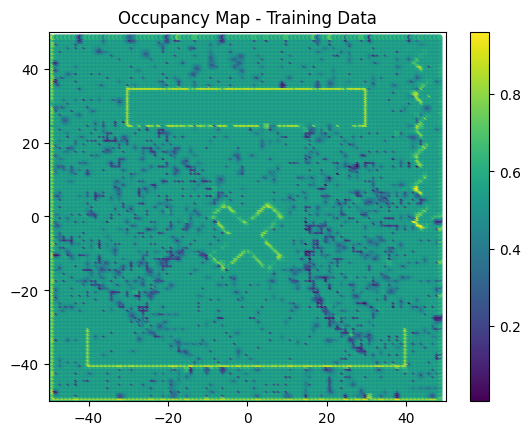

In [13]:
#query locations
q_resolution = 0.5
xx, yy = np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1]-1, q_resolution), np.arange(cell_max_min[2], cell_max_min[3]-1, q_resolution))
X_query = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

#query the model

Y_query = bhm_mdl.predict_proba(X_query)[:,1]

plt.scatter(X_query[:, 0], X_query[:, 1], c=Y_query, cmap='viridis', s=10, marker='8')

plt.title("Occupancy Map - Training Data")
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.colorbar()
plt.savefig('bhm_occupancy_map.png', dpi=500)

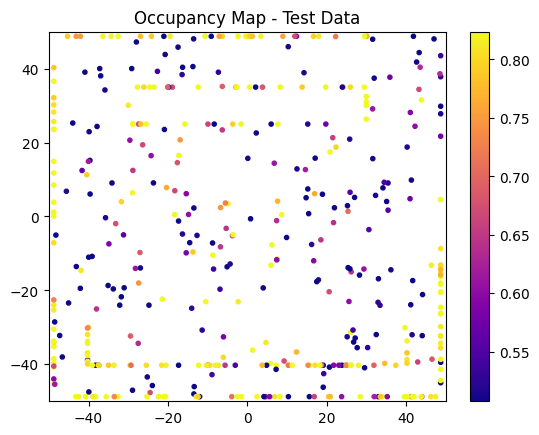

In [6]:
#query locations
q_resolution = 0.5
xx, yy = np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1]-1, q_resolution), np.arange(cell_max_min[2], cell_max_min[3]-1, q_resolution))
X_query = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

#query the model

y_trues = []
y_preds = []

for i in range(len(test_data["lidar_data"])):
    X_query = test_data["lidar_data"][i]
    Y_query = bhm_mdl.predict_proba(X_query)[:,1]

    y_trues.extend(test_data["occupancy"][i])
    y_preds.extend(Y_query)

    plt.scatter(X_query[:, 0], X_query[:, 1], c=Y_query, cmap='plasma', s=10, marker='8')

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

plt.title("Occupancy Map - Test Data")
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.colorbar()

In [7]:
print(len(y_trues), len(y_preds))
print(min(y_preds), max(y_preds))

445 445
0.10867115461494112 0.9571460633198949


In [8]:
min_pred = min(y_preds)
max_pred = max(y_preds)
thresholds = np.linspace(min_pred, max_pred, 200)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

auc = roc_auc_score(y_trues, y_preds)
print('AUC:', auc)

AUC: 0.9638514076295185


In [9]:
y_label_binary_list = []
y_preds_binary_list = []

for threshold in thresholds:
    y_preds_binary = np.zeros_like(y_preds)
    y_preds_binary[y_preds > threshold] = 1.0

    assert len(y_preds_binary) == len(y_trues)

    y_preds_binary_list.append(y_preds_binary)
    y_label_binary_list.append(y_trues)

assert len(y_preds_binary_list) == len(y_label_binary_list)

In [10]:
from highfrost.ogm.metrics import calculate_multiple_TP_FP_rates
tpr_list, fpr_list = calculate_multiple_TP_FP_rates(
    y_label_binary_list,
    y_preds_binary_list
)

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt

auc = metrics.auc(fpr_list, tpr_list)
auc

0.9587810261535898

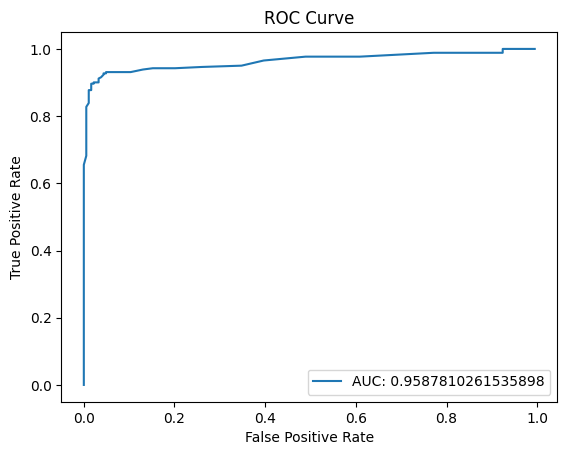

In [12]:
plt.plot(fpr_list, tpr_list, label=f"AUC: {auc}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")